In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 832)
(663976, 1)
validation
(128936, 832)
(128936, 1)
test
(61376, 832)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:40 - loss: 0.0729 - STD: 1.2820e-04 - MAE: 0.2590

 4/67 [>.............................] - ETA: 1s - loss: 0.0361 - STD: 2.9304e-04 - MAE: 0.1465  

 7/67 [==>...........................] - ETA: 1s - loss: 0.0348 - STD: 2.5804e-04 - MAE: 0.1440

10/67 [===>..........................] - ETA: 1s - loss: 0.0301 - STD: 3.0651e-04 - MAE: 0.1266

13/67 [====>.........................] - ETA: 1s - loss: 0.0269 - STD: 3.8834e-04 - MAE: 0.1204

16/67 [======>.......................] - ETA: 1s - loss: 0.0255 - STD: 4.6419e-04 - MAE: 0.1206

19/67 [=======>......................] - ETA: 2s - loss: 0.0240 - STD: 5.2622e-04 - MAE: 0.1149

22/67 [========>.....................] - ETA: 2s - loss: 0.0228 - STD: 5.7570e-04 - MAE: 0.1086

25/67 [==========>...................] - ETA: 2s - loss: 0.0218 - STD: 6.2468e-04 - MAE: 0.1038

28/67 [===========>..................] - ETA: 1s - loss: 0.0210 - STD: 6.8686e-04 - MAE: 0.1001

31/67 [============>.................] - ETA: 1s - loss: 0.0203 - STD: 7.6307e-04 - MAE: 0.0984

34/67 [==============>...............] - ETA: 1s - loss: 0.0197 - STD: 8.4929e-04 - MAE: 0.0977

37/67 [===============>..............] - ETA: 1s - loss: 0.0192 - STD: 9.4140e-04 - MAE: 0.0964

40/67 [================>.............] - ETA: 1s - loss: 0.0188 - STD: 0.0010 - MAE: 0.0945    

43/67 [==================>...........] - ETA: 0s - loss: 0.0185 - STD: 0.0012 - MAE: 0.0927

46/67 [===================>..........] - ETA: 0s - loss: 0.0181 - STD: 0.0013 - MAE: 0.0913

49/67 [====================>.........] - ETA: 0s - loss: 0.0178 - STD: 0.0015 - MAE: 0.0904

52/67 [======================>.......] - ETA: 0s - loss: 0.0175 - STD: 0.0017 - MAE: 0.0897

55/67 [=======================>......] - ETA: 0s - loss: 0.0172 - STD: 0.0019 - MAE: 0.0888

58/67 [========================>.....] - ETA: 0s - loss: 0.0170 - STD: 0.0022 - MAE: 0.0878

61/67 [==========================>...] - ETA: 0s - loss: 0.0168 - STD: 0.0026 - MAE: 0.0869

64/67 [===========================>..] - ETA: 0s - loss: 0.0165 - STD: 0.0031 - MAE: 0.0861

67/67 [==============================] - ETA: 0s - loss: 0.0163 - STD: 0.0037 - MAE: 0.0854

67/67 [==============================] - 5s 45ms/step - loss: 0.0163 - STD: 0.0037 - MAE: 0.0854 - val_loss: 0.0115 - val_STD: 0.0151 - val_MAE: 0.0664


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0100 - STD: 0.0199 - MAE: 0.0663

 4/67 [>.............................] - ETA: 1s - loss: 0.0103 - STD: 0.0229 - MAE: 0.0655

 7/67 [==>...........................] - ETA: 1s - loss: 0.0098 - STD: 0.0263 - MAE: 0.0633

10/67 [===>..........................] - ETA: 1s - loss: 0.0094 - STD: 0.0307 - MAE: 0.0621

13/67 [====>.........................] - ETA: 1s - loss: 0.0090 - STD: 0.0358 - MAE: 0.0608

16/67 [======>.......................] - ETA: 1s - loss: 0.0085 - STD: 0.0411 - MAE: 0.0593

19/67 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0464 - MAE: 0.0578

22/67 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.0516 - MAE: 0.0567

25/67 [==========>...................] - ETA: 0s - loss: 0.0074 - STD: 0.0557 - MAE: 0.0555

28/67 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0592 - MAE: 0.0545

31/67 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0622 - MAE: 0.0537

34/67 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0647 - MAE: 0.0529

37/67 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0673 - MAE: 0.0523

40/67 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0517

43/67 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0711 - MAE: 0.0513

46/67 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0509

49/67 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0742 - MAE: 0.0505

52/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0752 - MAE: 0.0501

55/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0764 - MAE: 0.0499

58/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0774 - MAE: 0.0496

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0494

64/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0491

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0490

67/67 [==============================] - 2s 26ms/step - loss: 0.0056 - STD: 0.0798 - MAE: 0.0490 - val_loss: 0.0034 - val_STD: 0.0772 - val_MAE: 0.0397


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0965 - MAE: 0.0448

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0954 - MAE: 0.0442

 7/67 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0958 - MAE: 0.0441

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0966 - MAE: 0.0440

13/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0959 - MAE: 0.0440

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0439

19/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0955 - MAE: 0.0439

21/67 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0439

24/67 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0959 - MAE: 0.0440

27/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0962 - MAE: 0.0439

30/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0961 - MAE: 0.0439

33/67 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0963 - MAE: 0.0439

36/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0963 - MAE: 0.0438

39/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0964 - MAE: 0.0438

42/67 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0963 - MAE: 0.0437

45/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0964 - MAE: 0.0437

48/67 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0963 - MAE: 0.0436

51/67 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0964 - MAE: 0.0435

54/67 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0966 - MAE: 0.0435

57/67 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0965 - MAE: 0.0434

60/67 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0967 - MAE: 0.0434

63/67 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0967 - MAE: 0.0434

66/67 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0968 - MAE: 0.0433

67/67 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0968 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0844 - val_MAE: 0.0398


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0415

 4/67 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0999 - MAE: 0.0423

 7/67 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0991 - MAE: 0.0422

10/67 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0983 - MAE: 0.0420

13/67 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0983 - MAE: 0.0419

16/67 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0984 - MAE: 0.0418

19/67 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0984 - MAE: 0.0417

22/67 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0416

25/67 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0985 - MAE: 0.0415

28/67 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0987 - MAE: 0.0415

31/67 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0985 - MAE: 0.0414

34/67 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0985 - MAE: 0.0414

37/67 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0987 - MAE: 0.0414

40/67 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0988 - MAE: 0.0413

43/67 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0412

46/67 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0412

49/67 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0411

52/67 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0411

55/67 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0990 - MAE: 0.0410

58/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0410

61/67 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0409

64/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0409

67/67 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0408

67/67 [==============================] - 2s 26ms/step - loss: 0.0036 - STD: 0.0993 - MAE: 0.0408 - val_loss: 0.0042 - val_STD: 0.0885 - val_MAE: 0.0428


Epoch 5/10000


 1/67 [..............................] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0392

 3/67 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0393

 6/67 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1001 - MAE: 0.0394

 9/67 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0999 - MAE: 0.0394

12/67 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1003 - MAE: 0.0394

15/67 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0393

18/67 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0393

21/67 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0393

24/67 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0392

27/67 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0391

30/67 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0391

33/67 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0390

36/67 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0390

39/67 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0390

42/67 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0389

45/67 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0389

48/67 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0389

51/67 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0388

54/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0388

57/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0388

60/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0388

63/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0387

66/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0387

67/67 [==============================] - 2s 26ms/step - loss: 0.0032 - STD: 0.1016 - MAE: 0.0387 - val_loss: 0.0044 - val_STD: 0.0912 - val_MAE: 0.0455


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0973 - MAE: 0.0385

 4/67 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.1008 - MAE: 0.0384

 7/67 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1011 - MAE: 0.0381

10/67 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0381

13/67 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0383

16/67 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0384

19/67 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0385

22/67 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0385

25/67 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0385

28/67 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0384

31/67 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0384

34/67 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0384

37/67 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0383

40/67 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0383

43/67 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0383

46/67 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0382

49/67 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0383

52/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0383

55/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0383

58/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0384

61/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0385

64/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0385

67/67 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0385

67/67 [==============================] - 2s 26ms/step - loss: 0.0032 - STD: 0.1023 - MAE: 0.0385 - val_loss: 0.0043 - val_STD: 0.0915 - val_MAE: 0.0438


Epoch 7/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1007 - MAE: 0.0378

 4/67 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

 7/67 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0374

10/67 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0375

13/67 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0375

16/67 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0374

19/67 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0374

22/67 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

25/67 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

28/67 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

31/67 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

34/67 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

37/67 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

40/67 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

43/67 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

46/67 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

49/67 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

52/67 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

55/67 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

58/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

61/67 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

64/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

67/67 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

67/67 [==============================] - 2s 26ms/step - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374 - val_loss: 0.0050 - val_STD: 0.0953 - val_MAE: 0.0452


Epoch 8/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0363

 4/67 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0370

 7/67 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

10/67 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0370

13/67 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0370

16/67 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0369

19/67 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0369

21/67 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0369

24/67 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0369

27/67 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0370

30/67 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0370

33/67 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0370

36/67 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0371

39/67 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0371

42/67 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0370

45/67 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0370

48/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0370

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0370

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0370

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0370

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0369

63/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0369

67/67 [==============================] - 2s 26ms/step - loss: 0.0029 - STD: 0.1035 - MAE: 0.0369 - val_loss: 0.0046 - val_STD: 0.0950 - val_MAE: 0.0449


Epoch 9/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0379

 4/67 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0370

 7/67 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0370

10/67 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0368

13/67 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0367

16/67 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0367

19/67 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0366

22/67 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0366

25/67 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0365

28/67 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0365

31/67 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0365

34/67 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0365

37/67 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0366

40/67 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0366

43/67 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0366

46/67 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0366

49/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0367

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0366

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0366

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0366

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0366

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0367

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0366

67/67 [==============================] - 2s 26ms/step - loss: 0.0029 - STD: 0.1038 - MAE: 0.0366 - val_loss: 0.0043 - val_STD: 0.0925 - val_MAE: 0.0443


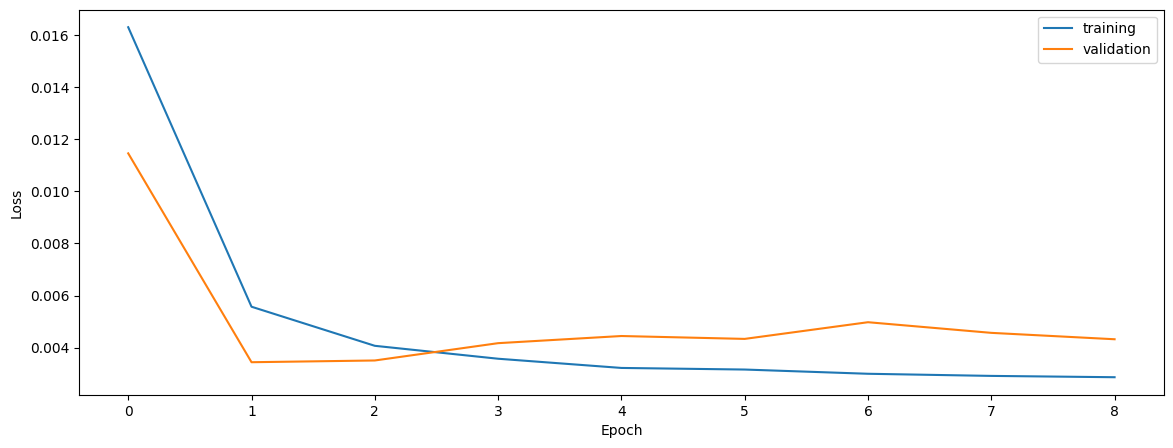

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8287869391727879
0.8752948249987196
0.7765669880735243


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8287869391727879
0.8752948249987196
0.7765669880735243


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8438451374424786
0.8862226195421163
0.8044831058558436


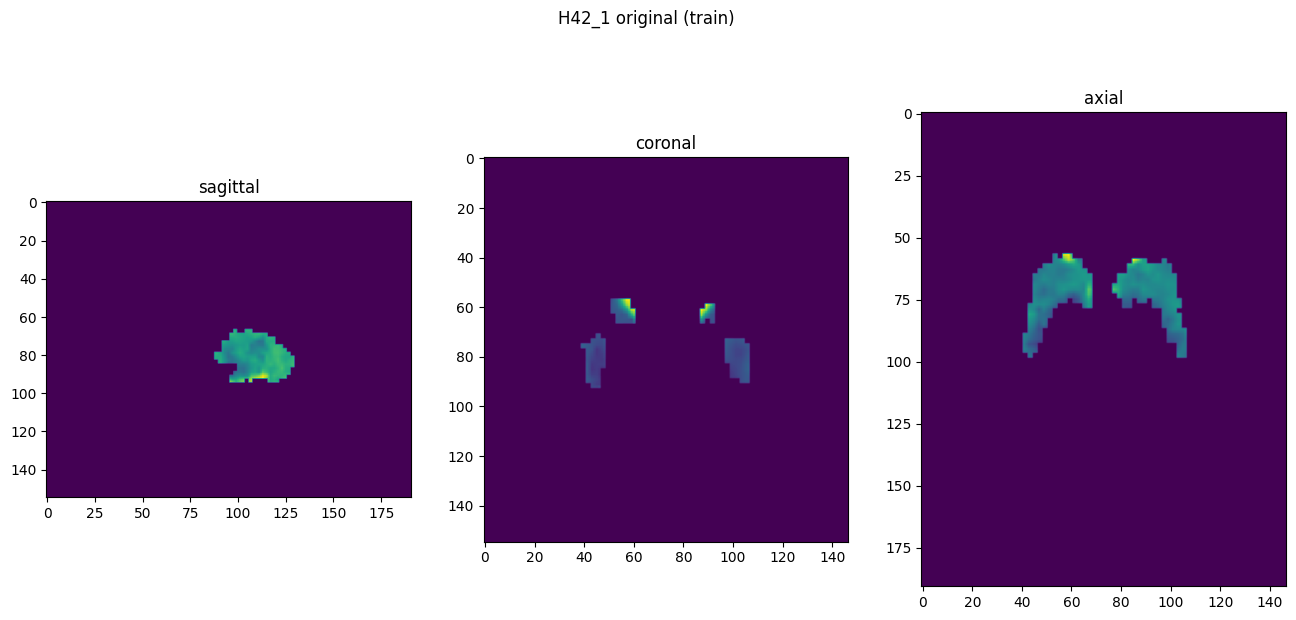

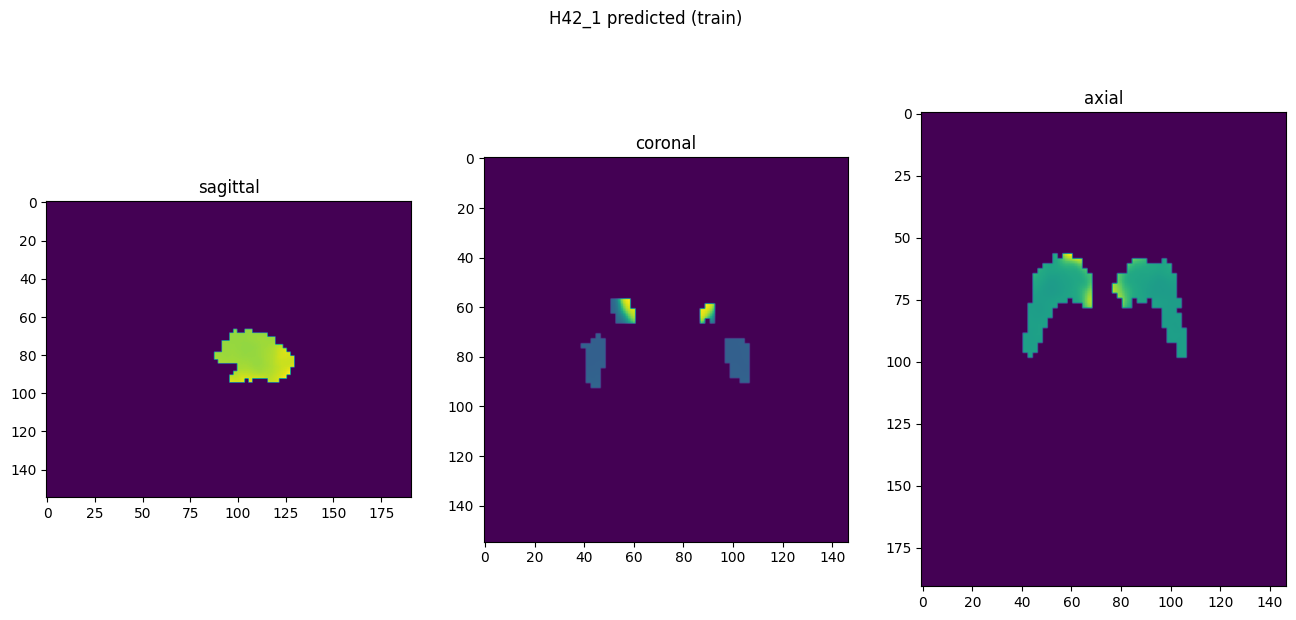

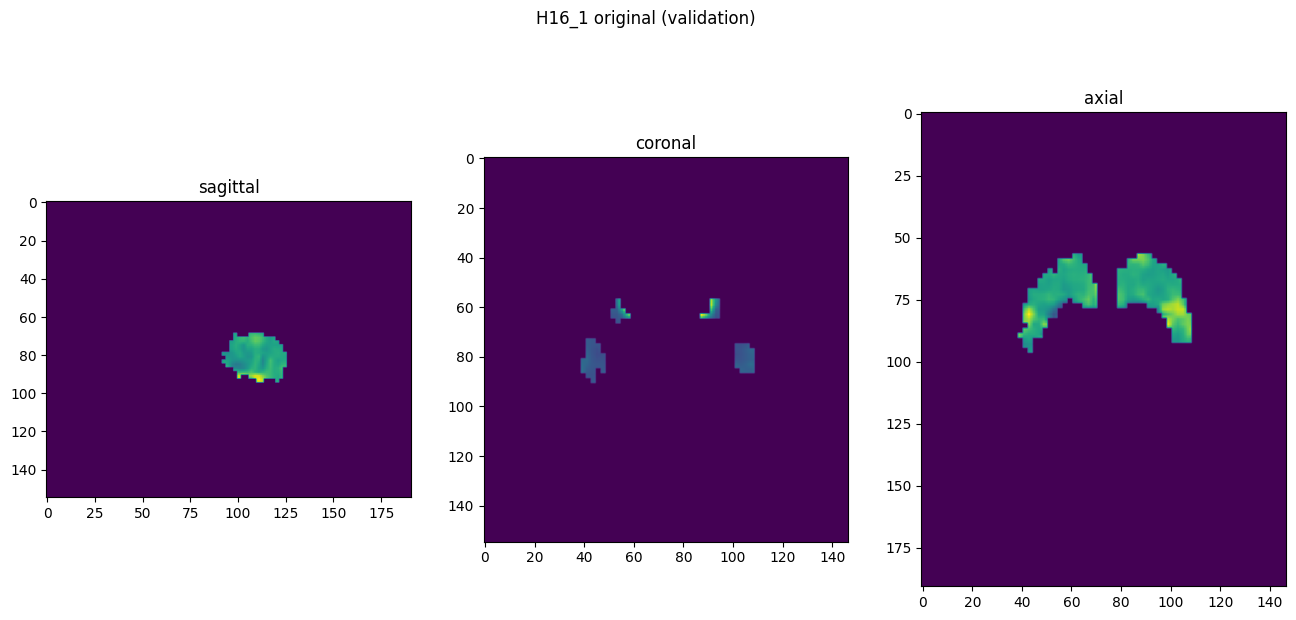

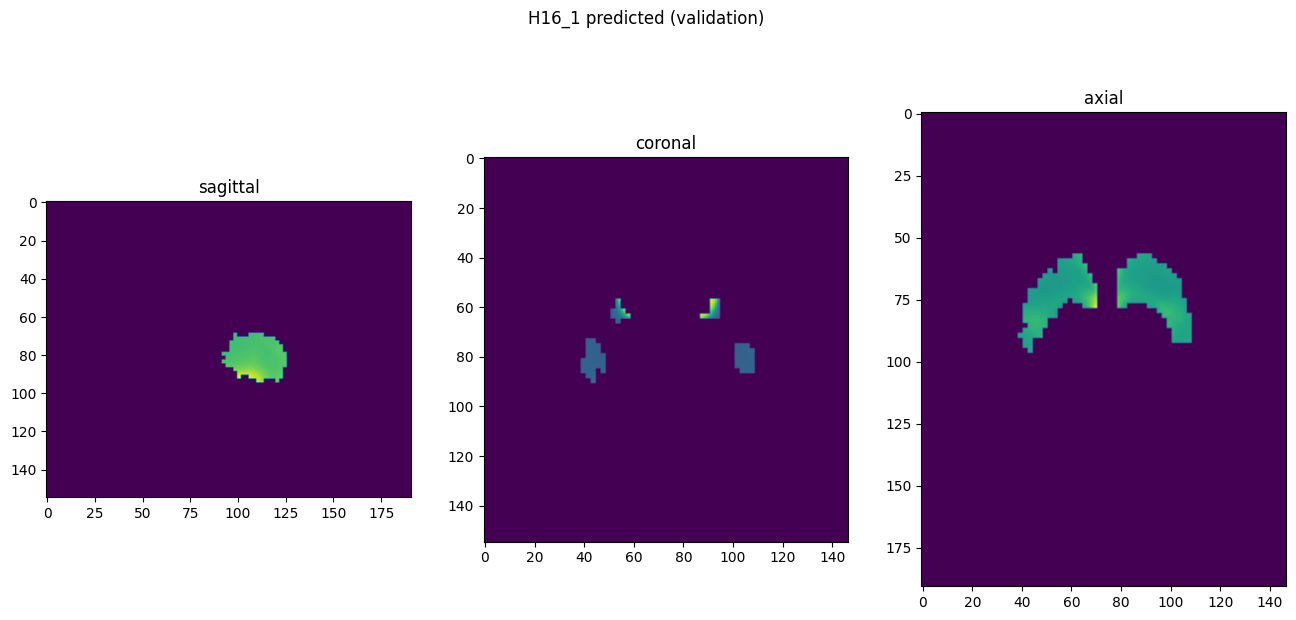

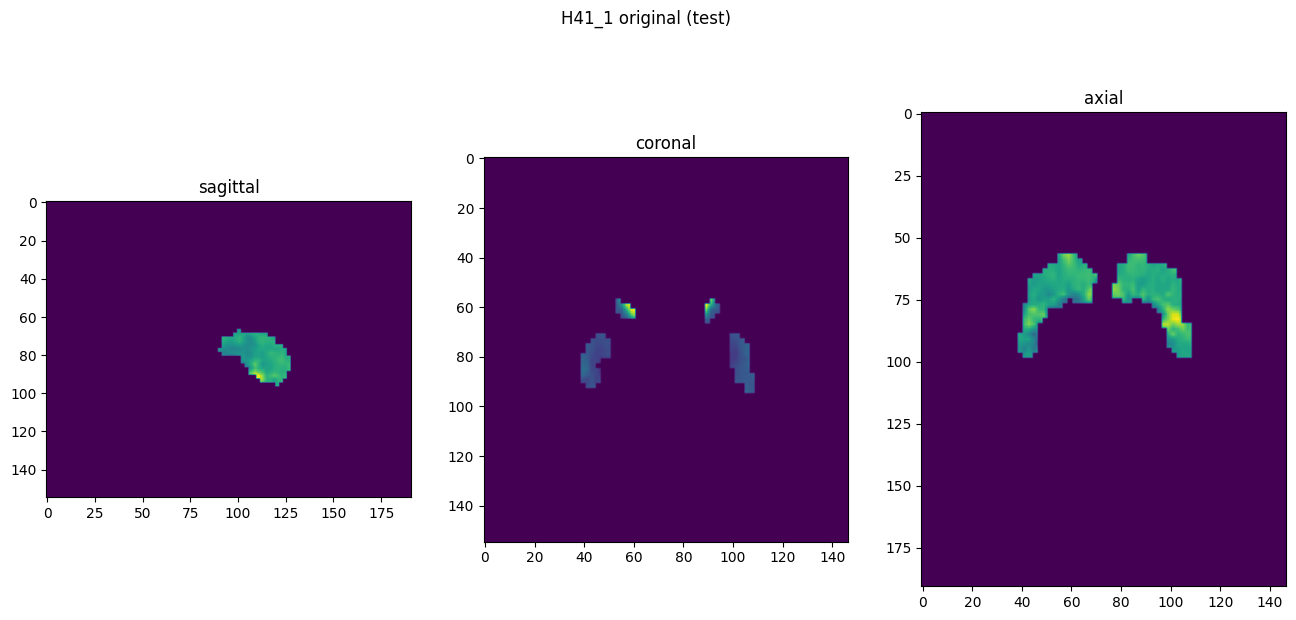

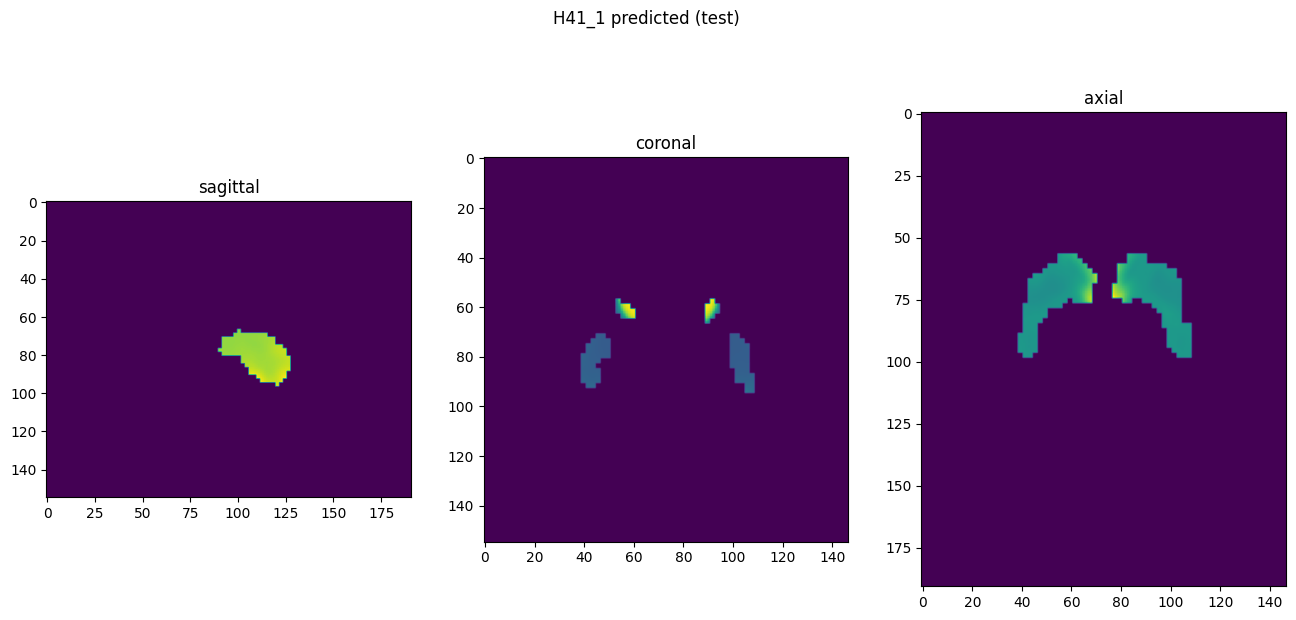

In [10]:
showResults(model, gen, threshold=None, background=False)